This notebook was inspired by : "Transfer Learning for NLP: Fine-Tuning BERT for Text Classification", Prateek Joshi — July 21, 2020, https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [1]:
# If using google drive, uncomment these 2 lines for accessing your myDrive folder
#from google.colab import drive
#drive.mount('/content/drive/')

# Install Libraries

In [2]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install transformers

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import time
from babel.dates import format_time
import matplotlib.pyplot as plt

# specify GPU or CPU
#device = torch.device("cuda")
device = torch.device("cpu")

# Enter here your local path to labelled data
PATH = ''

# Load Dataset

In [5]:
df_train = pd.read_csv(PATH + "Title_Train_Label.csv", usecols=['title', 'green_title'])
df_val   = pd.read_csv(PATH + "Title_Validation_Label.csv", usecols=['title', 'green_title'])
df_test  = pd.read_csv(PATH + "Test_Final.csv", usecols=['title', 'manual green'])
df_train.head(2)

,title,green_title
0,Senior Search Partner Manager,0.0
1,Head of Proposals,0.0


In [6]:
df_val.head(2)

,title,green_title
0,Betriebsmitarbeiter/in,-1
1,Infirmière Camp d'été,1


In [7]:
df_test.head(2)

,title,manual green
0,Business Process Engineers / Software Entwickl...,0
1,Kranführer/in mit SUVA Ausweis,0


In [8]:
# Size of training set
df_train.shape

(16193, 2)

In [9]:
# Check class distribution of train
df_train['green_title'].value_counts(normalize = True)

 0.0    0.823257
-1.0    0.139134
 1.0    0.037609
Name: green_title, dtype: float64

In [10]:
# Check class distribution of validation
df_val['green_title'].value_counts(normalize = True)

 0    0.769663
-1    0.172285
 1    0.058052
Name: green_title, dtype: float64

# Split train dataset into train, validation and test sets

In [11]:
train_text = df_train['title']
train_labels = df_train['green_title'].astype(int)
val_text = df_val['title']
val_labels = df_val['green_title'].astype(int)
test_text = df_test['title']

# Import BERT Model and BERT Tokenizer

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Tokenization

<AxesSubplot:>

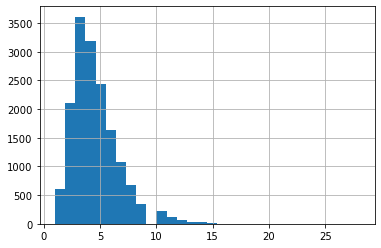

In [13]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [14]:
# set the max length to encore as 20 looking at the length distribution
max_seq_len = 20

In [15]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/Users/maximedulon/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [16]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor((train_labels+1).tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor((val_labels+1).tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

# Create DataLoaders

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
# Uncomment the following line if the validation set is large enough to sample validation data
# val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, batch_size=batch_size)
# Use the following line instead of the preceding one, if validation data sampling is desired
#val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [19]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [21]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
lr = 1e-3
optimizer = AdamW(model.parameters(), lr=lr)

# Find Class Weights

In [22]:
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights using validation_set distribution of labels
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(val_labels), y=val_labels)

print("Class Weights:", class_wts)

Class Weights: [1.93478261 0.43309002 5.74193548]


In [23]:
# convert class weights to tensor
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 100

# Fine-Tune BERT

In [24]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [25]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


for epoch in range(epochs):
     
    epoch_start_time = time.time()
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # train model
    train_loss, _ = train()
    
    # evaluate model
    valid_loss, _ = evaluate()
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_title.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nElapsed Time: {time.strftime("%Hh%Mm%Ss", time.gmtime(time.time() - epoch_start_time))}')


 Epoch 1 / 100
  Batch    50  of    507.
  Batch   100  of    507.
  Batch   150  of    507.
  Batch   200  of    507.
  Batch   250  of    507.
  Batch   300  of    507.
  Batch   350  of    507.
  Batch   400  of    507.
  Batch   450  of    507.
  Batch   500  of    507.

Evaluating...

Training Loss: 1.050
Validation Loss: 1.137

Elapsed Time: 00h00m47s

 Epoch 2 / 100
  Batch    50  of    507.
  Batch   100  of    507.
  Batch   150  of    507.
  Batch   200  of    507.
  Batch   250  of    507.
  Batch   300  of    507.
  Batch   350  of    507.
  Batch   400  of    507.
  Batch   450  of    507.
  Batch   500  of    507.

Evaluating...

Training Loss: 0.986
Validation Loss: 1.302

Elapsed Time: 00h00m44s

 Epoch 3 / 100
  Batch    50  of    507.
  Batch   100  of    507.
  Batch   150  of    507.
  Batch   200  of    507.
  Batch   250  of    507.
  Batch   300  of    507.
  Batch   350  of    507.
  Batch   400  of    507.
  Batch   450  of    507.
  Batch   500  of    507.

E

In [24]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

# Load Saved Model

In [26]:
#load weights of best model
path = 'saved_weights_title.pt'

# Use either one of the two following lines depending on GPU usage
#model.load_state_dict(torch.load(path))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

# Get final predictions for validation data

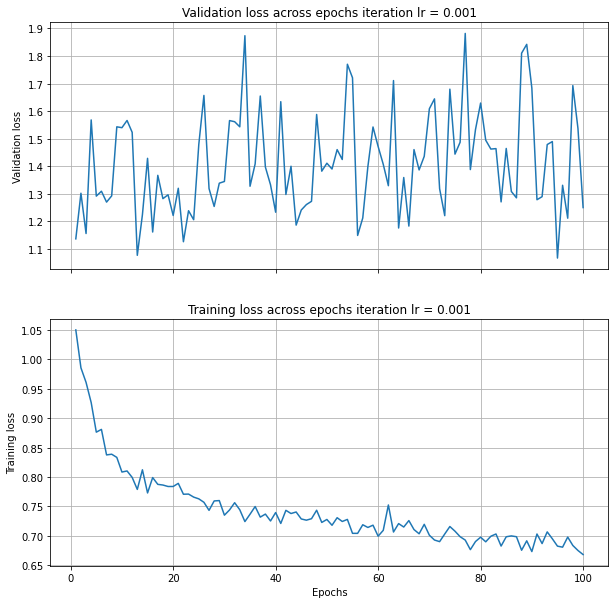

In [29]:
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize=(10,10))
ax1.plot(range(1, epochs+1), valid_losses)
#ax1.set_xlim([1, epochs])
plt_title_val = 'Validation loss across epochs iteration lr = ' + str(lr)
ax1.title.set_text(plt_title_val)
ax1.set_ylabel('Validation loss')
ax1.grid(True)


ax2.plot(range(1, epochs+1), train_losses)
plt_title_tr = 'Training loss across epochs iteration lr = ' + str(lr)
ax2.title.set_text(plt_title_tr)
ax2.set_ylabel('Training loss')
ax2.set_xlabel('Epochs')
ax2.grid(True)

fig.savefig('title_loss_epochs.png')

In [30]:
# get predictions for validation data
with torch.no_grad():
  preds = model(val_seq.to(device), val_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [31]:
# model's performance
# substract 1 to obtain labels [-1, 0, 1]
preds = np.argmax(preds, axis = 1) - 1
print(classification_report(val_labels, preds))

              precision    recall  f1-score   support

          -1       0.22      0.46      0.30        92
           0       0.78      0.55      0.65       411
           1       0.24      0.42      0.30        31

    accuracy                           0.53       534
   macro avg       0.41      0.48      0.42       534
weighted avg       0.66      0.53      0.57       534



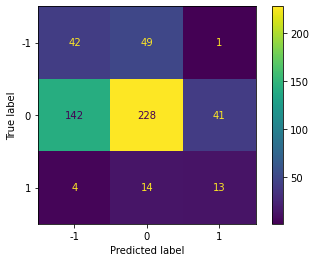

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(val_labels, preds), display_labels=np.unique(preds))
disp.plot()

# Make predictions for the test set

In [33]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  
# Substract 1 to obtain labels [-1, 0, 1]
preds = np.argmax(preds, axis = 1) - 1
preds

array([-1,  0,  0, -1,  0, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1,
       -1,  0,  1,  1, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0, -1, -1, -1,
       -1, -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0, -1, -1,  0,  0, -1,
       -1,  0, -1, -1, -1, -1,  1, -1, -1,  0,  0,  0, -1, -1, -1, -1,  0,
        0, -1,  0,  0, -1,  0,  0,  1,  1,  0,  0,  1,  0, -1, -1,  0, -1,
        0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  1,  0, -1,  0,  0,  0,  0,
        0,  0,  1,  0, -1,  0, -1,  0,  0, -1, -1,  0,  0,  0,  0,  1,  0,
       -1, -1,  1,  0,  0, -1, -1,  0, -1, -1, -1,  0,  0, -1,  0,  0, -1,
        0,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,
        1,  0,  0,  0,  0,  1, -1,  0, -1,  0,  0,  0,  0, -1, -1,  1, -1,
       -1,  0,  0, -1,  0, -1,  0,  0, -1, -1,  1, -1,  0,  1,  1, -1,  0,
        0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0, -1,  0,  0,  1,  0,  0,
        0, -1, -1,  0, -1, -1,  1, -1,  0,  0,  0,  0,  1,  0,  1, -1, -1,
       -1, -1,  1, -1,  0

In [34]:
# Add predictions to dataframe
df_test['green_title'] = preds

In [35]:
# Save dataframe
df_test.to_csv(PATH + 'Title_Prediction_BERT.csv', index=False)

# Alternative with forcing distributions

In [36]:
# Predictions on test set
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [37]:
# Percent distribution of green jobs wanted
wanted_green_distribution = 5
wanted_not_green_distribution = 10

df_test.loc[:, 'green_title'] = 0
df_test.loc[preds[:,1] > np.quantile(preds[:,1], 1-wanted_green_distribution/100), 'green_title'] = 1
df_test.loc[preds[:,2] > np.quantile(preds[:,2], 1-wanted_not_green_distribution/100), 'green_title'] = -1
df_test.to_csv(PATH + 'Title_Prediction_BERT_fixed.csv', index=False)